In [1]:
import pandas as pd

df = pd.read_pickle("data_clean.pkl")
dict = {'Real': 0, 'Fake': 1}
df["Type"] = df["Type"].map(dict)
df

,Month,Text,Type
0,"Feb,20",kuala lumpur tourism art culture ministry focu...,0
1,"Feb,20",kuching sarawak record four new patient invest...,0
2,"Feb,20",johor baru police open investigation paper spr...,0
3,"Feb,20",johor baru malaysian love like red red rise bl...,0
4,"Feb,20",petaling jaya one day least love trump even an...,0
...,...,...,...
885,"Nov,20",najib loot rm billion bond epf pas rm billion ...,1
886,"Nov,20",regret inform kelantan state ministry health t...,1
887,"Nov,20",due influence majority malaysian face salary p...,1
888,"Nov,20",oldtown curry noodle restaurant rumor contain ...,1


In [2]:
X = df[["Month", "Text"]]
y = df["Type"].values

In [3]:
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

In [3]:
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Stop words
stop_words = text.ENGLISH_STOP_WORDS

class BagOfWordsTransformer(TransformerMixin, BaseEstimator):
    def __init__(self, verbose=False, ngram=1):
        self.verbose = verbose
        self.ngram=ngram
        self.cv = CountVectorizer(stop_words=stop_words, ngram_range=(self.ngram, self.ngram), min_df=0.01)
    def fit(self, X, y=None):
        if(self.verbose):
            print("Verbose mode on!")
        self.cv.fit(X.Text)
        return self
    def transform(self, X):
        data_cv = self.cv.transform(X.Text)
        dtm = pd.DataFrame(data_cv.toarray(), columns=self.cv.get_feature_names())
        dtm.index = X.index
        return dtm

In [4]:
from sklearn.pipeline import Pipeline

bow_pipeline = Pipeline([
    ('bow_vectorizer', BagOfWordsTransformer(ngram=1)),
])

In [5]:
#X_train = bow_pipeline.fit_transform(X_train)
#X_val = bow_pipeline.transform(X_val)

X = bow_pipeline.fit_transform(X)

C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
X.shape

(890, 1355)

In [7]:
X.iloc[[0,1]]

,abd,abdul,abdullah,abide,able,abroad,abu,accept,access,accommodation,...,yang,yassin,year,yellow,yes,yesterday,young,youth,yusof,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Ensemble Model

In [13]:
from sklearn.naive_bayes import MultinomialNB
mnb_clf = MultinomialNB(alpha=0.84)

from sklearn.svm import SVC
svm_clf = SVC(kernel="rbf", C=9.0, gamma=0.00126)

from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth=5)

from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)

from sklearn.linear_model import LogisticRegression
log_reg_clf = LogisticRegression(solver="lbfgs", random_state=42, C=96)

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.63, random_state=42
)

In [14]:
from sklearn.ensemble import VotingClassifier
hard_voting_clf = VotingClassifier(
    estimators=[
        ('mnb', mnb_clf),
        ('svm', svm_clf),
        ('dt', dt_clf),
        ('rf', rf_clf),
        ('log_reg', log_reg_clf),
        ('adaboost', ada_clf)
    ],
    voting='hard'
)
#hard_voting_clf.fit(X_train, y_train)

In [15]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10)

In [16]:
for train_index, test_index in kf.split(X, y):
    print(train_index)
    print(test_index)
    break

[ 45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 29

In [17]:
%%time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import numpy as np
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

scores_mnb = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}
scores_svm = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}
scores_dt = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}
scores_rf = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}
scores_log_reg = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}
scores_ada = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}
#scores_hard_voting = {'train_acc':[], 'test_acc':[], 'train_f1':[], 'test_f1':[], 'train_precision':[], 'test_precision':[], 'train_recall':[], 'test_recall':[], 'train_auc':[], 'test_auc':[]}

lookup_clf = {0:scores_mnb, 1:scores_svm, 2:scores_dt, 3:scores_rf, 4:scores_log_reg, 5:scores_ada}


param_distributions_mnb = {'alpha': np.linspace(0, 2, 20), 'fit_prior': [True, False]}
param_distributions_svm = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
param_distributions_dt = {"max_depth": uniform(5, 100)}
param_distributions_rf = {"n_estimators": np.arange(5, 100)}
param_distributions_log = {"C": uniform(0.01, 100)}
param_distributions_ada = {"learning_rate": uniform(0, 2)}

param_distributions = [param_distributions_mnb, param_distributions_svm, param_distributions_dt, param_distributions_rf, param_distributions_log, param_distributions_ada]


for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]
    clf_list = [mnb_clf, svm_clf, dt_clf, rf_clf, log_reg_clf, ada_clf]
    for index, clf in enumerate(clf_list):
        print(f"Training {clf.__class__.__name__}")
        clf.fit(X_train, y_train)
        rnd_search_cv = RandomizedSearchCV(clf, param_distributions[index], n_iter=20, verbose=0, cv=5)
        rnd_search_cv.fit(X_train, y_train)
        y_train_pred = rnd_search_cv.predict(X_train)
        #print("Training Accuracy :", clf.__class__.__name__, accuracy_score(y_train, y_train_pred))
        y_pred = rnd_search_cv.predict(X_test)
        #print("Validation Accuracy :", clf.__class__.__name__, accuracy_score(y_val, y_pred))
        #print("Validation F1-score :", clf.__class__.__name__, f1_score(y_val, y_pred))
        #print()
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_pred)
        
        train_f1 = f1_score(y_train, y_train_pred)
        test_f1 = f1_score(y_test, y_pred)
        
        train_precision = precision_score(y_train, y_train_pred)
        test_precision = precision_score(y_test, y_pred)
        
        train_recall = recall_score(y_train, y_train_pred)
        test_recall = recall_score(y_test, y_pred)
        
        train_roc_auc_score = roc_auc_score(y_train, y_train_pred)
        test_roc_auc_score = roc_auc_score(y_test, y_pred)
        
        scores_clf = lookup_clf[index]
        
        scores_clf["train_acc"].append(train_accuracy)
        scores_clf["test_acc"].append(test_accuracy)
        
        scores_clf["train_f1"].append(train_f1)
        scores_clf["test_f1"].append(test_f1)
        
        scores_clf["train_precision"].append(train_precision)
        scores_clf["test_precision"].append(test_precision)
        
        scores_clf["train_recall"].append(train_recall)
        scores_clf["test_recall"].append(test_recall)
        
        scores_clf["train_auc"].append(train_roc_auc_score)
        scores_clf["test_auc"].append(test_roc_auc_score)

Training MultinomialNB


C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Training SVC
Training DecisionTreeClassifier
Training RandomForestClassifier
Training LogisticRegression
Training AdaBoostClassifier
Training MultinomialNB


C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Training SVC
Training DecisionTreeClassifier
Training RandomForestClassifier
Training LogisticRegression
Training AdaBoostClassifier
Training MultinomialNB


C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: al

Training SVC
Training DecisionTreeClassifier
Training RandomForestClassifier
Training LogisticRegression
Training AdaBoostClassifier
Training MultinomialNB
Training SVC
Training DecisionTreeClassifier
Training RandomForestClassifier
Training LogisticRegression
Training AdaBoostClassifier
Training MultinomialNB
Training SVC
Training DecisionTreeClassifier
Training RandomForestClassifier
Training LogisticRegression
Training AdaBoostClassifier
Training MultinomialNB
Training SVC
Training DecisionTreeClassifier
Training RandomForestClassifier
Training LogisticRegression
Training AdaBoostClassifier
Training MultinomialNB


C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Training SVC
Training DecisionTreeClassifier
Training RandomForestClassifier
Training LogisticRegression
Training AdaBoostClassifier
Training MultinomialNB
Training SVC
Training DecisionTreeClassifier
Training RandomForestClassifier
Training LogisticRegression
Training AdaBoostClassifier
Training MultinomialNB


C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Training SVC
Training DecisionTreeClassifier
Training RandomForestClassifier
Training LogisticRegression
Training AdaBoostClassifier
Training MultinomialNB


C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\munch\anaconda3\envs\nlu\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Training SVC
Training DecisionTreeClassifier
Training RandomForestClassifier
Training LogisticRegression
Training AdaBoostClassifier
Wall time: 42min 6s


In [27]:
np.arange(5, 10)

array([5, 6, 7, 8, 9])

In [19]:
import statistics
clf_list = [mnb_clf, svm_clf, dt_clf, rf_clf, log_reg_clf, ada_clf, hard_voting_clf]
ls = ["train_acc", "test_acc"]
for index, scores_clf in lookup_clf.items():
    clf_class = clf_list[index].__class__.__name__
    print(f"{clf_class}")
    for key, item in scores_clf.items():
        mean = statistics.mean(item)
        print(f"{key}: {mean}")
    print()

MultinomialNB
train_acc: 0.9652933832709114
test_acc: 0.9168539325842696
train_f1: 0.9642872641739695
test_f1: 0.9111972764395856
train_precision: 0.9817406931651564
test_precision: 0.959628127882858
train_recall: 0.9474747474747475
test_recall: 0.8704545454545455
train_auc: 0.9650953984287317
test_auc: 0.9163383838383838

SVC
train_acc: 0.9928838951310861
test_acc: 0.9629213483146067
train_f1: 0.9928117466238249
test_f1: 0.9621899009879912
train_precision: 0.9909419123650527
test_precision: 0.9621533696053413
train_recall: 0.9946969696969697
test_recall: 0.9636363636363636
train_auc: 0.9929040404040403
test_auc: 0.962929292929293

DecisionTreeClassifier
train_acc: 0.9962546816479401
test_acc: 0.9314606741573034
train_f1: 0.9961954391337202
test_f1: 0.9302710420676796
train_precision: 0.9977137492311179
test_precision: 0.9354848236139925
train_recall: 0.9946969696969697
test_recall: 0.9272727272727272
train_auc: 0.9962373737373738
test_auc: 0.9314141414141414

RandomForestClassifier
tr

In [223]:
from sklearn.ensemble import VotingClassifier
svm_clf = SVC(kernel="rbf", probability=True, C=9.0, gamma=0.00126)

soft_voting_clf = VotingClassifier(
    estimators=[
        ('mnb', mnb_clf),
        ('svm', svm_clf),
        ('rf', rf_clf),
        ('log_reg', log_reg_clf),
        ('adaboost', ada_clf)
    ],
    voting='soft'
)
soft_voting_clf.fit(X_train, y_train)

C:\Users\munch\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


VotingClassifier(estimators=[('mnb', MultinomialNB(alpha=0.84)),
                             ('svm',
                              SVC(C=9.0, gamma=0.00126, probability=True)),
                             ('rf',
                              RandomForestClassifier(n_estimators=1000,
                                                     random_state=42)),
                             ('log_reg',
                              LogisticRegression(C=96, random_state=42)),
                             ('adaboost',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                 learning_rate=0.63,
                                                 n_estimators=200,
                                                 random_state=42))],
                 voting='soft')

In [224]:
soft_voting_clf.fit(X_train, y_train)
y_pred = soft_voting_clf.predict(X_val)
print(soft_voting_clf.__class__.__name__, accuracy_score(y_val, y_pred))
y_train_pred = soft_voting_clf.predict(X_train)
print(soft_voting_clf.__class__.__name__, accuracy_score(y_train, y_train_pred))

C:\Users\munch\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


VotingClassifier 0.9662921348314607
VotingClassifier 1.0


In [131]:
X_val.shape

(178, 1355)

In [227]:
import pickle

with open('soft_voting_clf.pkl', 'wb') as f:
    pickle.dump(soft_voting_clf, f)

## Which news did the Ensemble Model predict wrongly

In [132]:
misclassified_ind = list(X_val[y_val != y_pred].index.values)

In [133]:
misclassified_ind

[106, 71, 372, 593, 21, 121, 703]

In [134]:
print("Real" if 1==1 else "Fake")

Real


In [135]:
misclassified_df

,Month,Text,Type
106,"Apr,20",petaling jaya selfemployed worker hit hard mov...,0
372,"Jul,20",ipoh senoi praaq battalion personnel general o...,0
257,"Nov,20",petaling jaya two foreign men confirm positive...,0
593,"Mar,20",kuala lumpur malaysia enough rice last two hal...,1
21,"Feb,20",johor baru despite scale follow coronavirus ou...,0
121,"Apr,20",petaling jaya malaysianborn doctor base united...,0
703,"May,20",kangar individual return abroad perlis conditi...,1


In [136]:
misclassified_df = df.filter(items=misclassified_ind, axis=0)
cv = CountVectorizer(stop_words=stop_words, ngram_range=(1, 1), min_df=0.01)
cv.fit(df.Text)
data_cv = cv.transform(misclassified_df.Text)
dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
dtm.index = misclassified_df.index

In [137]:
y_pred = soft_voting_clf.predict(dtm)

In [138]:
y_pred

array([1, 1, 1, 0, 1, 1, 0], dtype=int64)

In [140]:
for ind, item in enumerate(misclassified_df.iterrows()):
    print("Label :")
    print("Real" if item[1].Type == 0 else "Fake")
    print("Predicted Label:")
    print("Fake" if y_pred[ind] == 1 else "Real")
    print(item[1].Text)
    print("\n\n")

Label :
Real
Predicted Label:
Fake
petaling jaya selfemployed worker hit hard movement control order almost half work accord survey department statisticsand half still job majority experience drop income quite number lose incomethe online survey effect economy individual conduct march record response total people age year aboveselfemployed worker make total respondent surveyaccording survey lose jobsof still work almost experience drop income incomes drop employer make survey respondent people also hit badly workthe survey find employer experience drop income survey also find selfemployed worker saving could last one month ready mco extend furthersimilarly employer survey financially readyagriculture affect sector make lose job follow service sector 



Label :
Real
Predicted Label:
Fake
kota kinabalu petrol station city operate daily throughout movement control order period city hall issue statement matter saturday say line government effort fight apart petrol station eatery also see 

## Multinomial Naive Bayes. Multinomial distribution is suitable for text classification because it involves the probabilistic calculation of discrete integer feature counts. Bag of Words model generates discrete word counts

In [11]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

from sklearn.metrics import accuracy_score, f1_score, precision_score
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.9269662921348315
0.9212121212121213
0.987012987012987


In [12]:
mnb_pipeline = Pipeline([
    ('bow_vectorizer', bow_pipeline),
    ('mnb', MultinomialNB())
])

In [13]:
mnb_pipeline.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('bow_vectorizer',
                 Pipeline(steps=[('bow_vectorizer', BagOfWordsTransformer())])),
                ('mnb', MultinomialNB())])>

In [ ]:
param_grid_mnb = [
    {'alpha': np.linspace(0, 2, 20), 'fit_prior': [True, False]}
]

In [14]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = [
    {'alpha': np.linspace(0, 2, 20), 'fit_prior': [True, False]}
]

grid_search = GridSearchCV(model, param_grid, cv=3, return_train_score=True)
grid_search.fit(X_train, y_train)

C:\Users\munch\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\munch\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\munch\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\munch\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\munch\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in n

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid=[{'alpha': array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ]),
                          'fit_prior': [True, False]}],
             return_train_score=True)

In [15]:
grid_search.best_params_

{'alpha': 0.8421052631578947, 'fit_prior': False}

In [16]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.778085073691924 {'alpha': 0.0, 'fit_prior': True}
0.778085073691924 {'alpha': 0.0, 'fit_prior': False}
0.8918495668309517 {'alpha': 0.10526315789473684, 'fit_prior': True}
0.8918495668309517 {'alpha': 0.10526315789473684, 'fit_prior': False}
0.9058965358295218 {'alpha': 0.21052631578947367, 'fit_prior': True}
0.9058965358295218 {'alpha': 0.21052631578947367, 'fit_prior': False}
0.9073030055904218 {'alpha': 0.3157894736842105, 'fit_prior': True}
0.9073030055904218 {'alpha': 0.3157894736842105, 'fit_prior': False}
0.9157300050822016 {'alpha': 0.42105263157894735, 'fit_prior': True}
0.9157300050822016 {'alpha': 0.42105263157894735, 'fit_prior': False}
0.914329444858112 {'alpha': 0.5263157894736842, 'fit_prior': True}
0.914329444858112 {'alpha': 0.5263157894736842, 'fit_prior': False}
0.9185488541408123 {'alpha': 0.631578947368421, 'fit_prior': True}
0.919949414364902 {'alpha': 0.631578947368421, 'fit_prior': False}
0.9227505348130814 {'alpha': 0.7368421052631579, 'fit_prior': True}
0.92

## K-Nearest Neigbours, Poor Performance because of Curse of Dimensionality. Too many features (1000+)

In [31]:
from sklearn.neighbors import KNeighborsClassifier

optimal_k = 5
knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k)
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [32]:
y_pred = knn_classifier.predict(X_val)

from sklearn.metrics import accuracy_score, f1_score, precision_score
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.7134831460674157
0.7753303964757708
0.6330935251798561


## Support Vector Machines (SVM)

In [ ]:
param_distributions_svm = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}

In [48]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

svm_classifier = SVC(kernel="rbf")
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_classifier, param_distributions, n_iter=20, verbose=2, cv=3)
rnd_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=8.644074959660024, gamma=0.05872435932305266 ..................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ... C=8.644074959660024, gamma=0.05872435932305266, total=   0.3s
[CV] C=8.644074959660024, gamma=0.05872435932305266 ..................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ... C=8.644074959660024, gamma=0.05872435932305266, total=   0.3s
[CV] C=8.644074959660024, gamma=0.05872435932305266 ..................
[CV] ... C=8.644074959660024, gamma=0.05872435932305266, total=   0.3s
[CV] C=8.997985055738074, gamma=0.001257819045542782 .................
[CV] .. C=8.997985055738074, gamma=0.001257819045542782, total=   0.1s
[CV] C=8.997985055738074, gamma=0.001257819045542782 .................
[CV] .. C=8.997985055738074, gamma=0.001257819045542782, total=   0.1s
[CV] C=8.997985055738074, gamma=0.001257819045542782 .................
[CV] .. C=8.997985055738074, gamma=0.001257819045542782, total=   0.1s
[CV] C=7.2339929330956725, gamma=0.04830384719665792 .................
[CV] .. C=7.2339929330956725, gamma=0.04830384719665792, total=   0.3s
[CV] C=7.2339929330956725, gamma=0.04830384719665792 .................
[CV] .. C=7.2339929330956725, gamma=0.04830384719665792, total=   0.3s
[CV] C=7.2339929330956725, gamma=0.04830384719665792 .................
[CV] .

[CV] .. C=9.184878624804107, gamma=0.013947424936041114, total=   0.3s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   15.4s finished


RandomizedSearchCV(cv=3, estimator=SVC(), n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E7CF52ED30>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E7CF52E190>},
                   verbose=2)

In [49]:
rnd_search_cv.best_estimator_

SVC(C=8.997985055738074, gamma=0.001257819045542782)

In [50]:
rnd_search_cv.best_score_

0.9663038211065017

In [51]:
cvres = rnd_search_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8749719297001501 {'C': 8.644074959660024, 'gamma': 0.05872435932305266}
0.9663038211065017 {'C': 8.997985055738074, 'gamma': 0.001257819045542782}
0.8904194589228096 {'C': 7.2339929330956725, 'gamma': 0.04830384719665792}
0.8511033105225212 {'C': 10.806355674886793, 'gamma': 0.08153190916039757}
0.8623373399992907 {'C': 10.47042374115425, 'gamma': 0.07039873924590305}
0.8412875698802728 {'C': 2.84923247894502, 'gamma': 0.08866214251204353}
0.9663038211065017 {'C': 9.568253456767868, 'gamma': 0.0012612973492588035}
0.9381862449621199 {'C': 9.191887606625723, 'gamma': 0.021046798623336714}
0.9648973513456015 {'C': 4.2440184079082455, 'gamma': 0.0058557317526536585}
0.8721648997151603 {'C': 10.1292126356702, 'gamma': 0.060582680830766955}
0.89323239844461 {'C': 4.287245888593552, 'gamma': 0.04721821443620606}
0.9353733054403196 {'C': 6.181778629617878, 'gamma': 0.02291244297753815}
0.9100982165017905 {'C': 6.473731916996673, 'gamma': 0.03774115712356054}
0.9663038211065017 {'C': 8.98467

## Random Forest

In [ ]:
param_rf = []

In [57]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=1000, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_val)

In [58]:
from sklearn.metrics import accuracy_score, f1_score, precision_score
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.9550561797752809
0.9545454545454546
0.9545454545454546


## Logistic Regression

In [ ]:
param_distributions_log = {"C": uniform(0.01, 100)}

In [11]:
from sklearn.linear_model import LogisticRegression
log_reg_clf = LogisticRegression(solver="lbfgs", random_state=42)
log_reg_clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"C": uniform(0.01, 100)}

rnd_search_cv = RandomizedSearchCV(log_reg_clf, param_distributions, n_iter=50, verbose=2, cv=3)
rnd_search_cv.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] C=96.17412381288322 .............................................
[CV] .............................. C=96.17412381288322, total=   0.1s
[CV] C=96.17412381288322 .............................................
[CV] .............................. C=96.17412381288322, total=   0.0s
[CV] C=96.17412381288322 .............................................
[CV] .............................. C=96.17412381288322, total=   0.1s
[CV] C=24.575930580333296 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................. C=24.575930580333296, total=   0.1s
[CV] C=24.575930580333296 ............................................
[CV] ............................. C=24.575930580333296, total=   0.1s
[CV] C=24.575930580333296 ............................................
[CV] ............................. C=24.575930580333296, total=   0.1s
[CV] C=6.573306527891555 .............................................
[CV] .............................. C=6.573306527891555, total=   0.0s
[CV] C=6.573306527891555 .............................................
[CV] .............................. C=6.573306527891555, total=   0.1s
[CV] C=6.573306527891555 .............................................
[CV] .............................. C=6.573306527891555, total=   0.1s
[CV] C=18.79485560155848 .............................................
[CV] .............................. C=18.79485560155848, total=   0.1s
[CV] C=18.79485560155848 .............................................
[CV] .

[CV] ............................. C=16.449876099538756, total=   0.1s
[CV] C=16.449876099538756 ............................................
[CV] ............................. C=16.449876099538756, total=   0.1s
[CV] C=16.449876099538756 ............................................
[CV] ............................. C=16.449876099538756, total=   0.1s
[CV] C=15.531674413606966 ............................................
[CV] ............................. C=15.531674413606966, total=   0.1s
[CV] C=15.531674413606966 ............................................
[CV] ............................. C=15.531674413606966, total=   0.0s
[CV] C=15.531674413606966 ............................................
[CV] ............................. C=15.531674413606966, total=   0.1s
[CV] C=0.33880518638160884 ...........................................
[CV] ............................ C=0.33880518638160884, total=   0.0s
[CV] C=0.33880518638160884 ...........................................
[CV] .

[CV] .............................. C=79.03656714627441, total=   0.1s
[CV] C=98.14049501101563 .............................................
[CV] .............................. C=98.14049501101563, total=   0.1s
[CV] C=98.14049501101563 .............................................
[CV] .............................. C=98.14049501101563, total=   0.1s
[CV] C=98.14049501101563 .............................................
[CV] .............................. C=98.14049501101563, total=   0.1s
[CV] C=66.69094650044148 .............................................
[CV] .............................. C=66.69094650044148, total=   0.1s
[CV] C=66.69094650044148 .............................................
[CV] .............................. C=66.69094650044148, total=   0.1s
[CV] C=66.69094650044148 .............................................
[CV] .............................. C=66.69094650044148, total=   0.1s
[CV] C=57.55743020403982 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    8.0s finished


RandomizedSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
                   n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A0463E7250>},
                   verbose=2)

In [19]:
rnd_search_cv.best_estimator_

LogisticRegression(C=96.17412381288322, random_state=42)

In [20]:
rnd_search_cv.best_score_

0.9584584584584585

In [21]:
cvres = rnd_search_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9584584584584585 {'C': 96.17412381288322}
0.9573361240027906 {'C': 24.575930580333296}
0.9562099978766646 {'C': 6.573306527891555}
0.9573361240027906 {'C': 18.79485560155848}
0.9584584584584585 {'C': 98.53369779624859}
0.9584584584584585 {'C': 87.78360963240969}
0.9584584584584585 {'C': 76.82290248146266}
0.9562099978766646 {'C': 7.037848093730182}
0.9584584584584585 {'C': 89.60497229170957}
0.9562099978766646 {'C': 3.832759294813782}
0.9584584584584585 {'C': 51.81748708694529}
0.9584584584584585 {'C': 73.86608396290413}
0.9573361240027906 {'C': 14.44630825683594}
0.9584584584584585 {'C': 98.19292731127989}
0.9584584584584585 {'C': 69.48453486635702}
0.9573323323323324 {'C': 2.196590425376533}
0.9573361240027906 {'C': 21.78117924396003}
0.9584584584584585 {'C': 61.45219497645829}
0.9584584584584585 {'C': 61.128097970517345}
0.9584584584584585 {'C': 32.5177322480937}
0.9584584584584585 {'C': 82.80772429901927}
0.9573361240027906 {'C': 16.449876099538756}
0.9573361240027906 {'C': 15.53

## Adaboost

In [ ]:
param_distributions_ada = {"learning_rate": uniform(0, 2)}

In [64]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", random_state=42
)

In [67]:
param_distributions = {"learning_rate": uniform(0, 2)}

rnd_search_cv = RandomizedSearchCV(ada_clf, param_distributions, n_iter=20, verbose=2, cv=3)
rnd_search_cv.fit(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] learning_rate=0.7449401411086163 ................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. learning_rate=0.7449401411086163, total=   1.9s
[CV] learning_rate=0.7449401411086163 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ................. learning_rate=0.7449401411086163, total=   1.8s
[CV] learning_rate=0.7449401411086163 ................................
[CV] ................. learning_rate=0.7449401411086163, total=   1.9s
[CV] learning_rate=0.5699614745716512 ................................
[CV] ................. learning_rate=0.5699614745716512, total=   1.9s
[CV] learning_rate=0.5699614745716512 ................................
[CV] ................. learning_rate=0.5699614745716512, total=   1.9s
[CV] learning_rate=0.5699614745716512 ................................
[CV] ................. learning_rate=0.5699614745716512, total=   1.9s
[CV] learning_rate=0.6903953767852085 ................................
[CV] ................. learning_rate=0.6903953767852085, total=   1.8s
[CV] learning_rate=0.6903953767852085 ................................
[CV] ................. learning_rate=0.6903953767852085, total=   1.8s
[CV] learning_rate=0.6903953767852085 ................................
[CV] .

[CV] ................. learning_rate=1.5359409575084622, total=   1.9s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.9min finished


RandomizedSearchCV(cv=3,
                   estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                                n_estimators=200,
                                                random_state=42),
                   n_iter=20,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E7CF8A02B0>},
                   verbose=2)

In [68]:
rnd_search_cv.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.62905054942068, n_estimators=200,
                   random_state=42)

In [69]:
rnd_search_cv.best_score_

0.969666636333303

In [70]:
cvres = rnd_search_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9606841690175023 {'learning_rate': 0.7449401411086163}
0.9606879606879607 {'learning_rate': 0.5699614745716512}
0.9595580428913761 {'learning_rate': 0.6903953767852085}
0.9562062062062062 {'learning_rate': 1.9476466100809495}
0.9539349956016623 {'learning_rate': 0.8210230387933066}
0.9595580428913761 {'learning_rate': 1.7604591154582108}
0.9618140868140869 {'learning_rate': 0.5227839135962051}
0.9584319167652501 {'learning_rate': 0.534528661874029}
0.969666636333303 {'learning_rate': 0.62905054942068}
0.9438226104892772 {'learning_rate': 1.9225877394523332}
0.9528088694755361 {'learning_rate': 1.9433342228108736}
0.9651772985106319 {'learning_rate': 1.5555476075235293}
0.9662996329662997 {'learning_rate': 1.2005294909061195}
0.9606879606879607 {'learning_rate': 0.5704155361600407}
0.9595618345618346 {'learning_rate': 1.8086471333424754}
0.9584508751175419 {'learning_rate': 0.5500482303341634}
0.9595618345618346 {'learning_rate': 0.49260588058581045}
0.9539387872721207 {'learning_rate

## Playing with Scipy Reciprocal function

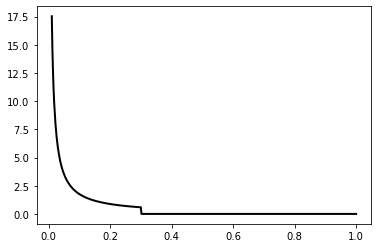

In [40]:
from scipy.stats import reciprocal
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
rv = reciprocal(0.001, 0.3)
x = np.linspace(0.01, 1.0, 500)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')